Eva MANUKYAN, Florine PRITZY, Caroline REBOUILLAT, Elisa SEBASTIAN

# Project B) Image classification

## Task

> With a dataset of food/drinks/brands/logos, create a multilabel image classification model using any pretrained model (e.g. VGG16, InceptionV3, EfficientDet/EfficientNet, etc.) <br><br>
Minimum requirements: find/collect and, if needed, annotate enough data for at least 3 classes; use built-in data augmentation functions (e.g. from tensorflow); use transfer learning techniques to train a model; evaluate it on test data; provide and explain how can you apply this model in marketing/market research field to find insights from pictures.<br><br>
Desirable: Use Albumenatations for image augmentation; make some photos and test your model on them; test your model on random pictures of landscapes/inside-outside environments/etc; provide possible marketing ideas of it.


## Marketing issue

- In marketing, image recognition allows to calculate how much more exposure a specific brand gets from their logo being visible in the images shared across social channels.
- Image recognition can also be especially useful, for example for social media agencies on Instagram images, to monitor visual conversations about their clients' and competitors' brands - and then join in the chat.
- Image recognition can also make it possible to recommend products based on the objects seen by a potential customer. In our case, for example, one of the brands could send an offer to a customer who has posted a photo near their restaurant.
- Image recognition can allow to have a complete vision of brand's online reputation by detecting "hidden" visual mentions that cannot be reported by traditional monitoring platforms
- Image recognition can also allow to the brand to compare its visual presence to that of its competitors. In fucntion, of results that there are getting, some strategies can be established. 


## Description of the database

Our database corresponds to video from several shopping mall at Ankara in Turkey where images were extracted by a group of students at Atilim University.<br>
The goal is to predict 6 brand logos (6 classes) : Subway, Starbucks, McDonalds, KFC, Burger King and other.
-	450 images for Burger King
-	90 images for KFC
-	285 images for Mcdonalds
-	271 images for Starbucks
-	153 images for Subway
-	1049 images for other<br><br>

As we can see our database is unbalanced. Unbalanced data is a problem for many machine learning tools. Sometimes we cannot get optimized results for the minority class as the model/algorithm never gets sufficient look at the underlying class. But to counter this problem, image augmentation will be particularly useful (you will see our explanation later in the notebook).<br><br>The test set will be composed of images that are not relative to the original base but of photos that we will have taken (10 photos per class).

## Summary of our project

With the database we presented just before, we will first use data augmentation function using Albumentations. 
Then we will use transfer techniques, and more specifically use a pre-trained model: InceptionV3. On this pretrained model we will build our own neural network.
We will also create our own neural network. 
Finally, we will test the model on our 90 photos. 

## Code

### Import libraries

In [1]:
import psutil
import humanize
import os
from IPython.display import display_html
import numpy as np 
import pandas as pd 
import numpy as np
import keras
import tensorflow as tf
from keras import backend as K
from keras.layers import *
from keras.models import Sequential
from keras.models import Model
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from keras.models import model_from_json
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


#For Florine 
import os
print(os.listdir("/Users/FlorinePritzy/Documents/big data et marketing/archive-2/logos3"))
dataDirectory= "/Users/FlorinePritzy/Documents/big data et marketing/archive-2/logos3" 
print(os.listdir(dataDirectory))

### Import directories for images

We extract the path of our data, for more simplicity in the code afterwards. 

In [2]:
#For Eva 
import os
print(os.listdir("/Users/evamanukyan/Documents/faculté/MAG3-EBDS/Big Data in marketing /archive"))
dataDirectory= "/Users/evamanukyan/Documents/faculté/MAG3-EBDS/Big Data in marketing /archive/logos_v3_mini/logos3" 
print(os.listdir(dataDirectory))

['.DS_Store', 'logos_v3_mini', 'logos3']
['.DS_Store', 'test', 'train']


Our images have no masks. They are in 6 different folders. We must therefore extract the name of these 6 different folders to get the labels of our images in the train and the test set. 

In [3]:
train_path = dataDirectory+'/train'
test_path  = dataDirectory+'/test'

> Select classes

In [4]:
#['Burger King','KFC','McDonalds','Other','Starbucks','Subway'] 
selectedClasses = ['Burger King', 'KFC','McDonalds','Other', 'Starbucks', 'Subway'] 
print(selectedClasses)
class_ind = {selectedClasses[i]:i for i in range(6)}
print(class_ind)

['Burger King', 'KFC', 'McDonalds', 'Other', 'Starbucks', 'Subway']
{'Burger King': 0, 'KFC': 1, 'McDonalds': 2, 'Other': 3, 'Starbucks': 4, 'Subway': 5}


### Augmentation Pipeline : Albumentations

The goal is to preprocess image before feeding it into network. In our case, we will artificially expand the size of a training dataset by creating modified versions of images in the dataset.<br><br>
**Why do we need to generate random data?** A small amount of data is not sufficient to have a model robust. Expand the training dataset will improve the performance and ability of the model to generalize.

**Image augmentation** artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc.

**Albumentations** is a fast and flexible image augmentation library. Albumentations efficiently implements a rich variety of image transform operations that are optimized for performance.

Albumentations requires Python 3.6 or higher. To install the latest version from PyPI:
*pip install -U albumentations*


In [5]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations as A

#They will be applied to 20, 30 or 15% of instances of input data, so we have 3 differents probabilities : 

p1 = 0.20
p2 = 0.30
p3 = 0.15

augmentations = A.Compose([
    A.ChannelDropout(channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=p3),
    A.ChannelShuffle(p=p2),
    A.HorizontalFlip(p=p3),
    A.Flip(p=p1),
    A.RandomCrop(width=224, height=224, p=p3)

])

**Explanations of arguments in augmentations :**
- 1) **ChannelDropout** = Randomly Drop Channels in the input Image
- 2) **ChannelShuffle** = Randomly rearrange channels of the input RGB image
- 3) **HorizontalFlip** = Flip the input horizontally
- 4) **Flip** = Flip the input both horizontally and vertically
- 5) **RandomCrop** = Crop a random part of the input

### ImageDataAugmentor pipeline :

Use a package on Github : ImageDataAugmentor to apply augmentations pipeline on train, test and validation datagenerator.<br><br>
pip install git+https://github.com/mjkvaak/ImageDataAugmentor <br><br> The usage is analogous to tensorflow.keras' ImageDataGenerator with the exception that the image transformations will be generated using external augmentations libraries<br><br>We need this package because after we want to use .flow_from_directory to import our images and we cannot use this commande direclty with Augmentations <br><br> We apply a rescaling, augmentations and validation split to train and only rescaling to test set

In [6]:
train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = augmentations,
        validation_split=0.1,#Validation split 10%. 
        preprocess_input=None)
        

In [7]:
test_datagen = ImageDataAugmentor(
    rescale=1./255)

### Create 3 generators : Train_generator, test_generator and validation_generator

Now, we can import our images in train, test and validation generators. flow_from_directory() is used to read images from a large numeric array and folders containing images. A validation set was created, manually by sampling images from the train folder and moving them to a new folder called "validation".
The attributes we used with .flow_from_directory are : 
- 1) **the directory** = path where ‘n’ classes of folders are present
- 2) **target_size** = size of our input images, every image will be resized to this size
- 3) **batch_size** = number of images to be yielded from the generator per batch
- 4) **class_mode** = number of classes we have

In [8]:
batchSize=32

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=batchSize,
        classes=selectedClasses,
        subset='training')

Found 1554 images belonging to 6 classes.


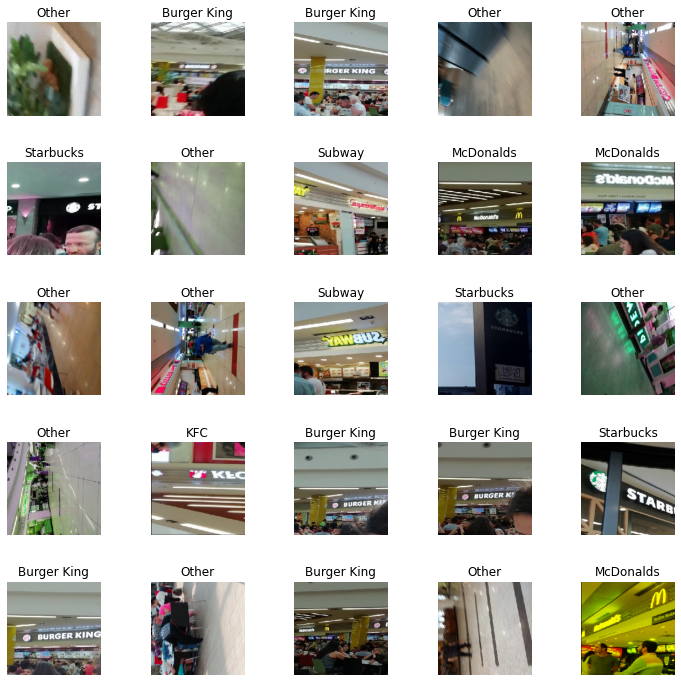

In [9]:
train_generator.show_batch() #<- for visualization

We can see that in the train generator we have normally imported images and transformed images (pink, blue, yellow and flip filters) 

In [10]:
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=batchSize,
        classes=selectedClasses)

Found 90 images belonging to 6 classes.


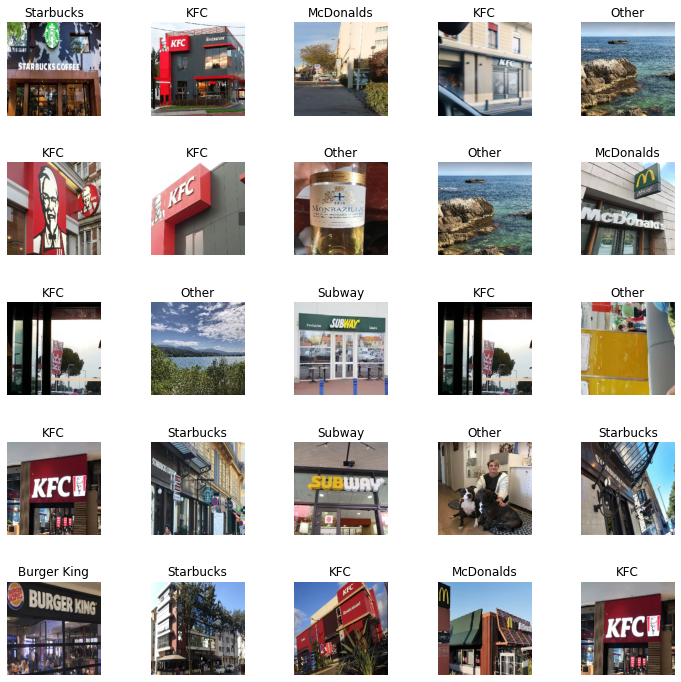

In [11]:
test_generator.show_batch() #<- for visualization : our pictures 

We can see in the test generator, our own images (photo of McDonalds, KFC or Starbucks in Marseille)

In [12]:
validation_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=batchSize,
        classes=selectedClasses,
        subset='validation')

Found 170 images belonging to 6 classes.


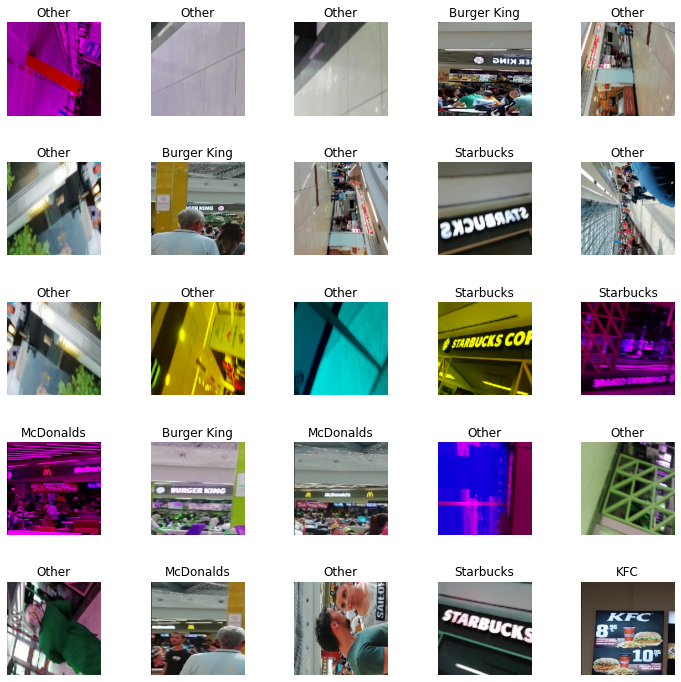

In [13]:
validation_generator.show_batch()

We can see that in the validation generator we have normally imported images and transformed images (pink, blue, yellow and flip filters) because it's 10% of the train set. 

**Number of samples of each class in all data generators :**

In [14]:
print ("In train_generator ")
for cls in range(len (train_generator.class_indices)):
    print(selectedClasses[cls],":\t",list(train_generator.classes).count(cls))
print ("") 

print ("In validation_generator ")
for cls in range(len (validation_generator.class_indices)):
    print(selectedClasses[cls],":\t",list(validation_generator.classes).count(cls))
print ("") 

print ("In test_generator ")
for cls in range(len (test_generator.class_indices)):
    print(selectedClasses[cls],":\t",list(test_generator.classes).count(cls))

In train_generator 
Burger King :	 265
KFC :	 61
McDonalds :	 169
Other :	 741
Starbucks :	 208
Subway :	 110

In validation_generator 
Burger King :	 29
KFC :	 6
McDonalds :	 18
Other :	 82
Starbucks :	 23
Subway :	 12

In test_generator 
Burger King :	 15
KFC :	 15
McDonalds :	 15
Other :	 15
Starbucks :	 15
Subway :	 15


### Create model by Transfer Learning from InceptionV3

> **Transfer learning** is a technique in machine learning which consist in reusing a model developed for a task.<br>
In our case, we will download **pre-trained model** and its weights from Keras. We are going to use the **InceptionV3** pretrained model.<br><br>**History:**
- The “Inception” micro-architecture has been introduced by Szegedy et al.: It acts like a multilevel feature extractor by computing 1×1, 3×3, and 5×5 convolutions within the same module of the network.
- The "Inception V3" architecture core comes from later another time by Szegedy et al. They propose updates to boost ImageNet classification accuracy.

In this cell, we are getting "pure" pretrained model from keras and not tf.keras, because otherwise it is not working.

In [15]:
!rm -r ~/.keras
!mkdir ~/.keras
!mkdir ~/.keras/models
# not enough space for both
#!cp ../input/keras-pretrained-models/* ~/.keras/models/ 
#!cp ../input/vgg19/* ~/.keras/models
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/
#!cp ../input/keras-pretrained-models/resnet50* ~/.keras/models/

zsh:1: no matches found: ../input/keras-pretrained-models/*notop*
cp: ../input/keras-pretrained-models/imagenet_class_index.json: No such file or directory


**The following code will be base on tree task:**
- Inception V3 architecture with frozen layers
- Add some new trainable layers on the top of the frozen layers
- Train the new layers on our dataset

In [16]:
InceptionV3

base_model = InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224, 224,3))

# Include top is false: we do not include the fully connected at the top, as the last layer of the network.
# Input shape: the shape of our input is (224,224,3) - size of images and color

base_model.trainable = False

#After taking layers from the trained model InceptionV3, we use the previous code in order to freeze them 
# This avoid destroying any of the information they contain during future training rounds.

#Then, we add some new trainable layers on the top of the frozen layers
#They will learn to turn the old features into predictions on a new dataset.
model = Sequential()
#64 convolution filters used each of size 3x3  #choose the best features via pooling
model.add(MaxPooling2D(pool_size=(3, 3)))
#randomly turn neurons on and off to improve convergence
model.add(Dropout(0.8))
#flatten since too many dimensions, we only want a classification output
model.add(Flatten())
#fully connected to get all relevant data
model.add(Dense(224, activation='relu'))
#one more dropout for convergence
model.add(Dropout(0.5))
#output a softmax to squash the matrix into output probabilities
predictions = model.add(Dense(len(selectedClasses), activation='sigmoid'))

#Then, we train the new layers on our dataset. 
pretrainedInput = base_model.input
pretrainedOutput = base_model.output
output = model(pretrainedOutput)
model = Model(pretrainedInput, output)

model.summary()

87916544/87910968 [==============================] - 11s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________

We propose the following code in order to see the architecture of the neural network. Unfortunately, the code is not working anymore (we could not resolve the problem), but we have saved the architecture of this precise neural network when it was working. The problem can come from upgrades in packages. 

In [ ]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


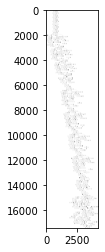

In [26]:
model_plot = cv2.imread('/Users/evamanukyan/Documents/faculté/MAG3-EBDS/Big Data in marketing /model_plot.png')
plt.imshow(model_plot)
plt.show()

**Here are some additional information about the new trainable layers on the top of the frozen layers**

**- Max pooling**

The main idea behind a pooling layer is to “accumulate” features from maps generated by convolving a filter over an image.
Formally, its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network. The most common form of pooling is max pooling.

Max pooling is done to in part to help over-fitting by providing an abstracted form of the representation.

As well, it reduces the computational cost by reducing the number of parameters to learn and provides basic translation invariance to the internal representation. Max pooling is done by applying a max filter to (usually) non-overlapping subregions of the initial representation.

**- DROPOUT**<br>A single model can be used to simulate having a large number of different network architectures by randomly dropping out nodes during training. 
This is called dropout and offers a very computationally cheap and remarkably effective regularization method to reduce overfitting and improve generalization error in deep neural networks of all kinds.

Dropout is a regularization method that approximates training a large number of neural networks with different architectures in parallel.

During training, some number of layer outputs are randomly ignored or “dropped out.” 
This has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer. 
In effect, each update to a layer during training is performed with a different “view” of the configured layer.

**- Choice of the activation function**

It is used to determine the output of neural network like yes or no. It maps the resulting values in between 0 to 1 or -1 to 1 etc. (depending upon the function).

The main reason why we use **sigmoid function** is because it exists between (0 to 1). Therefore, it is *especially used for models where we have to predict the probability as an output*.

Since probability of anything exists only between the range of 0 and 1, sigmoid is the right choice.
The function is differentiable.That means, we can find the slope of the sigmoid curve at any two points.
The function is monotonic but function’s derivative is not.

Other functions:
- The *logistic sigmoid* function can cause a neural network to get stuck at the training time.
- The *softmax function* is a more generalized logistic activation function which is used for multiclass classification. Generally, we use softmax activation instead of sigmoid with the cross-entropy loss because softmax activation distributes the probability throughout each output node. But, since it is a binary classification, using sigmoid is same as softmax. For multi-class classification use sofmax with cross-entropy.

However, with softmax function the performance of our model is worse, so we decided to keep going with sigmoid one.  

### Compile the model

Once we have defined our network, we must compile it.

**Compilation is an efficiency step.** It transforms the simple sequence of layers that we defined into a highly efficient series of matrix transforms in a format intended to be executed on your GPU or CPU, depending on how Keras is configured.


Compilation is always required after defining a model. This includes both before training it using an optimization scheme as well as loading a set of pre-trained weights from a save file. The reason is that the compilation step prepares an efficient representation of the network that is also required to make predictions on your hardware.

Here we ae going to use optimization algorithms named **ADAM** that requires the tuning of learning rate.

**Adam is an optimization algorithm** that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data.

The algorithms leverages the power of adaptive learning rates methods to find individual learning rates for each parameter.

Adam can be looked at as a combination of RMSprop (RMSprop is a gradient based optimization technique used in training neural networks) and Stochastic Gradient Descent with momentum. It uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself.

*Advantages of **ADAM**:*
- The method is too fast and converges rapidly. 
- Rectifies vanishing learning rate, high variance.

*Disadvantages of **ADAM**:*
- Computationally costly.


In [19]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

### Train the model

**We will calculate steps_per_epoch and validation_steps for fit_generator.**

We want to see how many steps we need to yield from generator before declaring one epoch finished and strating to the next one. 

This number has to be equal to the number of samples in the dataset divided by the batch size (32).

In [20]:
stepsPerEpoch= (train_generator.samples+ (batchSize-1)) // batchSize
print("stepsPerEpoch: ", stepsPerEpoch)

validationSteps=(validation_generator.samples+ (batchSize-1)) // batchSize
print("validationSteps: ", validationSteps)


stepsPerEpoch:  49
validationSteps:  6


**Train**<br>
Increasing the number of epochs to increase the accurcacy of the model. 

In [21]:
history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=6,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        verbose=1)

Epoch 1/6
49/49 [==============================] - 284s 6s/step - loss: 1.9942 - accuracy: 0.3713 - val_loss: 1.4194 - val_accuracy: 0.4824
Epoch 2/6
49/49 [==============================] - 262s 5s/step - loss: 1.4081 - accuracy: 0.4955 - val_loss: 0.8624 - val_accuracy: 0.4941
Epoch 3/6
49/49 [==============================] - 261s 5s/step - loss: 1.1145 - accuracy: 0.6145 - val_loss: 1.0684 - val_accuracy: 0.6235
Epoch 4/6
49/49 [==============================] - 260s 5s/step - loss: 0.9191 - accuracy: 0.6737 - val_loss: 1.0531 - val_accuracy: 0.7118
Epoch 5/6
49/49 [==============================] - 259s 5s/step - loss: 0.8358 - accuracy: 0.6988 - val_loss: 0.8217 - val_accuracy: 0.7882
Epoch 6/6
49/49 [==============================] - 264s 5s/step - loss: 0.6846 - accuracy: 0.7561 - val_loss: 0.3689 - val_accuracy: 0.8118


**Showing the model accuracy**


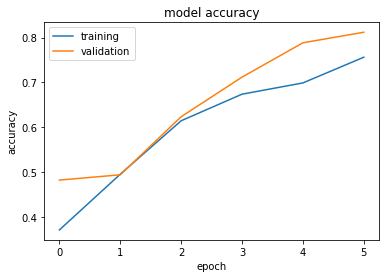

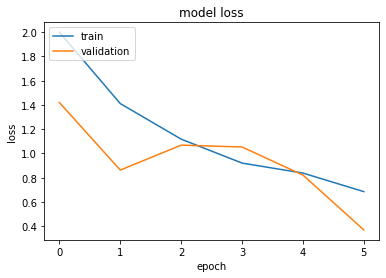

In [22]:
#loss_and_metrics  = model.evaluate(test, train, verbose=2)
#print("Test Accuracy", loss_and_metrics[1])

training_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

plt.plot(training_acc)
plt.plot(test_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [23]:
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


### Evaluate the model on our images

evaluate_generator(generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)

Evaluating the model, we arrived at maximum 36% of the accuracy. The accuracy is changing with every execution because of random image transformation which are done on the train set.

In [24]:
test_generator.reset()
score = model.evaluate_generator(test_generator, (test_generator.samples + (batchSize-1)) //batchSize)
print("For test data set; Loss: ",score[0]," Accuracy: ", score[1])

For test data set; Loss:  2.8623225688934326  Accuracy:  0.30000001192092896


**Make Predictions**

We need to reset the test_generator before whenever you call the predict_generator. 
This is important, to not end up with outputs in a weird order.

In [27]:
test_generator.reset()
testStep = (test_generator.samples + (batchSize-1)) // batchSize
print("testStep: ", testStep)
predictions = model.predict_generator(test_generator, steps = testStep ,  verbose = 1)
len(predictions)

testStep:  3
3/3 [==============================] - 7s 2s/step


90

### Decode Labels
Now predictions has the probabilities for 6 classes for each test case!

We can find the class with the highest probability as the prediction label as follows:

In [28]:
predicted_class_indices=np.argmax(predictions,axis=1)
print(predicted_class_indices)
len(predicted_class_indices)

[0 3 4 0 3 2 2 3 4 3 4 0 4 4 0 4 0 3 4 0 0 3 2 0 0 3 0 0 3 0 2 2 0 3 4 4 3
 2 4 3 0 0 0 0 0 4 4 4 0 0 4 0 4 2 3 3 4 0 4 0 0 4 4 4 0 0 4 2 0 0 4 0 0 4
 4 3 4 0 4 0 0 4 0 4 0 0 3 0 3 0]


90

In [29]:
labels = (test_generator.class_indices)

labels = dict((v,k) for k,v in labels.items())
print(labels)

{0: 'Burger King', 1: 'KFC', 2: 'McDonalds', 3: 'Other', 4: 'Starbucks', 5: 'Subway'}


In [30]:
predictedLables= [labels[k] for k in predicted_class_indices]
print(predictedLables)
len(predictedLables)

['Burger King', 'Other', 'Starbucks', 'Burger King', 'Other', 'McDonalds', 'McDonalds', 'Other', 'Starbucks', 'Other', 'Starbucks', 'Burger King', 'Starbucks', 'Starbucks', 'Burger King', 'Starbucks', 'Burger King', 'Other', 'Starbucks', 'Burger King', 'Burger King', 'Other', 'McDonalds', 'Burger King', 'Burger King', 'Other', 'Burger King', 'Burger King', 'Other', 'Burger King', 'McDonalds', 'McDonalds', 'Burger King', 'Other', 'Starbucks', 'Starbucks', 'Other', 'McDonalds', 'Starbucks', 'Other', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Starbucks', 'Starbucks', 'Starbucks', 'Burger King', 'Burger King', 'Starbucks', 'Burger King', 'Starbucks', 'McDonalds', 'Other', 'Other', 'Starbucks', 'Burger King', 'Starbucks', 'Burger King', 'Burger King', 'Starbucks', 'Starbucks', 'Starbucks', 'Burger King', 'Burger King', 'Starbucks', 'McDonalds', 'Burger King', 'Burger King', 'Starbucks', 'Burger King', 'Burger King', 'Starbucks', 'Starbucks', 'Other', 'Starbu

90

predictedLabels have the labels predicted by the model. We need to locate the actual labels for the same test data as follows:

In [31]:
actualLables= [labels[k] for k in test_generator.classes]
print(actualLables)
len(actualLables)

['Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'KFC', 'KFC', 'KFC', 'KFC', 'KFC', 'KFC', 'KFC', 'KFC', 'KFC', 'KFC', 'KFC', 'KFC', 'KFC', 'KFC', 'KFC', 'McDonalds', 'McDonalds', 'McDonalds', 'McDonalds', 'McDonalds', 'McDonalds', 'McDonalds', 'McDonalds', 'McDonalds', 'McDonalds', 'McDonalds', 'McDonalds', 'McDonalds', 'McDonalds', 'McDonalds', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Starbucks', 'Starbucks', 'Starbucks', 'Starbucks', 'Starbucks', 'Starbucks', 'Starbucks', 'Starbucks', 'Starbucks', 'Starbucks', 'Starbucks', 'Starbucks', 'Starbucks', 'Starbucks', 'Starbucks', 'Subway', 'Subway', 'Subway', 'Subway', 'Subway', 'Subway', 'Subway', 'Subway', 'Subway', 'Subway', 'Subway', 'Subway', 'Subway', 'Subway', 'Sub

90

In [1]:
predictedLables

NameError: name 'predictedLables' is not defined

In [32]:
accuracy_score(actualLables, predictedLables)

0.17777777777777778

To see what is the category that the classifier has difficulties to recognize

In [33]:
matrix = confusion_matrix(actualLables, predictedLables)
print(labels)
matrix

{0: 'Burger King', 1: 'KFC', 2: 'McDonalds', 3: 'Other', 4: 'Starbucks', 5: 'Subway'}


array([[4, 0, 2, 4, 5, 0],
       [8, 0, 1, 4, 2, 0],
       [6, 0, 3, 3, 3, 0],
       [5, 0, 1, 2, 7, 0],
       [7, 0, 1, 0, 7, 0],
       [8, 0, 0, 3, 4, 0]])

### The precision and recall metrics

Several metrics can be derived from a confusion matrix. For example, recall metrics. 


Recall, in other words, the ability of a model is designed to find all the relevant cases within a dataset. 

The precise definition of recall is the number of true positives divided by the number of true positives plus the number of false negatives. True positives are data point classified as positive by the model that actually are positive (meaning they are correct), and false negatives are data points the model identifies as negative that actually are positive (incorrect).


The precision and recall metrics are probably the most common metrics derived from such a table.

P = TP / (TP + FP)

R = TP / (TP + FN)

For example, What's the precision and recall of 'Burger King' in this case?

The utility function classification_report prints the precision and recall values for all the categories. (The F1 score combines the precision and recall values into a single value.)

According to results, our classifier can't identify labels of brands: KFC, McDonalds and Subway.  

In [34]:
print(classification_report(actualLables, predictedLables))

              precision    recall  f1-score   support

 Burger King       0.11      0.27      0.15        15
         KFC       0.00      0.00      0.00        15
   McDonalds       0.38      0.20      0.26        15
       Other       0.12      0.13      0.13        15
   Starbucks       0.25      0.47      0.33        15
      Subway       0.00      0.00      0.00        15

    accuracy                           0.18        90
   macro avg       0.14      0.18      0.14        90
weighted avg       0.14      0.18      0.14        90



/Applications/anaconda3/envs/KERAS/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Appendix and libraries

- https://keras.io/guides/transfer_learning/
- https://www.kaggle.com/kmkarakaya/logos-bk-kfc-mcdonald-starbucks-subway-none
- https://albumentations.ai
- https://www.analyticsvidhya.com/blog/2020/02/learn-image-classification-cnn-convolutional-neural-networks-3-datasets/

In [35]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
